# Transport network density

## Introduction

This notebook is based on the [eu_grid_population.py](https://github.com/GISAdamToth/characteristics_of_transport_network_toolbox/blob/main/python_scripts/eu_grid_population.py) script, which is part of the [Calculation possibilies of transport network's characteristics of countries and cities](https://www.geoinformatics.upol.cz/dprace/bakalarske/toth22/) bachelor thesis by Adam Tóth (2022).

In this notebook you will calculate the transport network density in two ways:
1) "classic" approach, where density = length / area
2) "demographic" approach, where density = length / population

You'll need a cloned ArcGIS Python environment so you can run [**ArcPy**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/get-started/what-is-arcpy-.htm) functions and install additional packages.

The workflow is divided into the following sections:
- [ArcGIS setup](#arcgis)
- [Transport network data](#osmnx)
- [Population data](#popgrid)
- [Hexagonal grid](#hex)
- [Density calculation](#calc)
- [Visualization](#vis)

## ArcGIS setup <a id="arcgis"></a>

Start ArcGIS Pro and create a new project.

Import **ArcPy** and allow overwriting outputs with the same name.

In [2]:
import arcpy
arcpy.env.overwriteOutput = True

Save the path to your project's geodatabase and set it as the workspace.

In [3]:
workspace_dir = "D:/transport_netw_char/"
workspace_gdb = "D:/transport_netw_char/transport_netw_char.gdb/"
arcpy.env.workspace = workspace_gdb

## Transport network data <a id="osmnx"></a>

Transport network is a term which covers all parts of the transport infrastructure in a certain area, typically country, region or city. Transport network therefore includes roads, railways, airports, river and sea ports (harbours), pipelines, all kinds of junctions, terminals and so on. This notebook focuses on the line features of transport network, because the density is expressed as **length** either per area or per capita. 

Therefore you can use any kind of line layer representing highways, streets, railways for example. In this part you'll go through the process of accessing railways data from OpenStreetMap (OSM) and getting them ready for further work in ArcGIS Pro.

This part is inspired by the notebook [Accessing OSM Data in Python](https://pygis.io/docs/d_access_osm.html) published at PyGIS.

You'll need [**OSMnx**](https://osmnx.readthedocs.io/en/stable/) and [**GeoPandas**](https://geopandas.org/en/stable/) packages. There are various ways how to install them into your cloned ArcGIS Python environment, one simple way is to uncomment and execute the next two code lines.

In [ ]:
# %pip install osmnx
# %pip install geopandas

Import the packages now.

In [4]:
import osmnx as ox
import geopandas as gpd

c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-proda-clone\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Area of interest

The first step is to choose the area of interest. You can choose any European city, region or country. For this notebook the area of interest will be the Liverpool city in the UK.

In [4]:
place_name = "Liverpool, UK"

Using the functionality of imported packages, save the area of interest as a GeoDataFrame into the variable ```area``` and check how is looks like.

In [5]:
area = ox.geocode_to_gdf(place_name)
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-3.01917 53.43616, -3.01806 53.43323...",53.474989,53.311543,-2.818,-3.019173,271544355,relation,172987,53.407199,-2.99168,boundary,administrative,16,0.670751,city,Liverpool,"Liverpool, Liverpool City Region, England, Uni..."


You can also verify its data type and plot it using [**matplotlib**](https://matplotlib.org/) built-in the **GeoPandas** package.

In [ ]:
print(type(area))
area.plot()

Save now this polygon GeoDataFrame into a geojson file, so you can later import it into the geodatabase in ArcGIS Pro.

In [6]:
area.to_file(workspace_dir + 'liverpool_boundary.geojson', driver='GeoJSON')
area = 'liverpool_boundary'

Import the geojson file with area of interest into your geodatabase.

In [7]:
arcpy.conversion.JSONToFeatures(workspace_dir + 'liverpool_boundary.geojson', area, "POLYGON")

<Result 'D:/transport_netw_char/transport_netw_char.gdb\\liverpool_boundary'>

### OSM data

In [9]:
# get all types of railways (https://wiki.openstreetmap.org/wiki/Map_features#Railway)
tags = {'railway': True}  
# get only rails = "Full sized passenger or freight train tracks in the standard gauge for the country or state." 
#tags = {'railway': 'rail'}  

railways = ox.features_from_place(place_name, tags)
railways.head()

railway                   geometry  \
element_type osmid                                          
node         24817480   switch  POINT (-2.88837 53.35797)   
             24817497   switch  POINT (-2.86186 53.35360)   
             24825496     stop  POINT (-2.94467 53.40238)   
             24825515  station  POINT (-2.92282 53.40522)   
             25296243     stop  POINT (-2.88881 53.35825)   

                              loading_gauge ref:lor  \
element_type osmid                                    
node         24817480                   NaN     NaN   
             24817497  W6A, W7, W8, W9, W10  NW2001   
             24825496                   NaN     NaN   
             24825515                   NaN     NaN   
             25296243                   NaN     NaN   

                                            name public_transport  ref train  \
element_type osmid                                                             
node         24817480                        NaN              NaN  NaN   NaN   
             24817497                        NaN              NaN  NaN   NaN   
             24825496                  Edge Hill    stop_position    3   yes   
             24825515  Wavertree Technology Park          station  NaN   yes   
             25296243    Liverpool South Parkway    stop_position  NaN   yes   

                      naptan:AtcoCode        network  ... building height  \
element_type osmid                                    ...                   
node         24817480             NaN            NaN  ...      NaN    NaN   
             24817497             NaN            NaN  ...      NaN    NaN   
             24825496             NaN            NaN  ...      NaN    NaN   
             24825515     9100WVRTTEC  National Rail  ...      NaN    NaN   
             25296243             NaN            NaN  ...      NaN    NaN   

                      min_height underground landuse historic:bridge highway  \
element_type osmid                                                             
node         24817480        NaN         NaN     NaN             NaN     NaN   
             24817497        NaN         NaN     NaN             NaN     NaN   
             24825496        NaN         NaN     NaN             NaN     NaN   
             24825515        NaN         NaN     NaN             NaN     NaN   
             25296243        NaN         NaN     NaN             NaN     NaN   

                      surface ways type  
element_type osmid                       
node         24817480     NaN  NaN  NaN  
             24817497     NaN  NaN  NaN  
             24825496     NaN  NaN  NaN  
             24825515     NaN  NaN  NaN  
             25296243     NaN  NaN  NaN  

[5 rows x 108 columns]

In [ ]:
print(len(railways))
railways.plot()

In [10]:
railways = railways.loc[:,railways.columns.str.contains('addr:|geometry')]

c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-thesis-clone\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


938


c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-thesis-clone\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

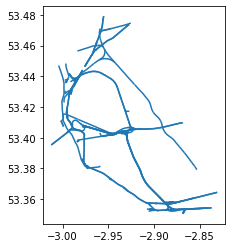

In [11]:
rails = railways.loc[railways.geometry.type=='LineString']
print(len(rails))
rails.plot()

In [12]:
rails.to_file(workspace_dir + 'liverpool_rails.geojson', driver='GeoJSON')
rails = 'liverpool_rails'

c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-thesis-clone\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Import the geojson file with rails into your geodatabase.

In [13]:
arcpy.conversion.JSONToFeatures(workspace_dir + 'liverpool_rails.geojson', rails, "POLYLINE")

c:\Users\dzuky\AppData\Local\ESRI\conda\envs\arcgispro-py3-thesis-clone\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Result 'D:/transport_netw_char/transport_netw_char.gdb\\liverpool_rails'>

## Population data <a id="popgrid"></a>

Install necessary libraries.

In [ ]:
# %pip install os
# %pip install requests
# %pip install zipfile

Import them.

In [14]:
import os
import requests
import zipfile

Set parameters and variables for downloading zipped population grid from the eurostat website.

In [15]:
# URL of the population grid to download
url = "https://ec.europa.eu/eurostat/cache/GISCO/geodatafiles/JRC_GRID_2018.zip"

# Define the file name and path for saving the downloaded file
file_name = "JRC_GRID_2018.zip"
file_path = os.path.join(workspace_dir, file_name)  # Save in the workspace directory

Send a GET request to the URL to download the file

In [ ]:
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content to a file
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f"File '{file_name}' downloaded successfully!")
else:
    print("Failed to download the file.")

Extract (unzip) the downloaded file.

In [ ]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(file_path[:-4] + '/')

Save the path to the extracted population grid shapefile itself.

In [16]:
pop_data = file_path[:-4] + '/JRC_POPULATION_2018.shp'
pop_data

'D:/transport_netw_char/JRC_GRID_2018/JRC_POPULATION_2018.shp'

Select the population grid "pixels" that intersect with the area of interest. Copy or export these "pixels" into your workspace and then don't forget to clear the selection.

In [18]:
area_selection = arcpy.management.SelectLayerByLocation(pop_data, "INTERSECT", area)
arcpy.management.CopyFeatures(area_selection, "pop_data_liverpool")
area_selection = arcpy.management.SelectLayerByAttribute(pop_data, "CLEAR_SELECTION")

Save the "pixel" area size in a new field which will be named ```"area_orig"```. You will make a copy of the ```"Shape_Area"``` field basically.

In [8]:
arcpy.management.AddField("pop_data_liverpool", "area_orig", "DOUBLE")
arcpy.management.CalculateField("pop_data_liverpool", "area_orig", '!Shape_Area!')

ExecuteError: ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
ERROR 000574: Python is not installed.
Failed to execute (CalculateField).


Clip the copied/exported population grid "pixels" by the area of interest.

In [ ]:
arcpy.analysis.Clip("pop_data_liverpool", area, "clipped_pop_data")
pop_data = "clipped_pop_data"

Add a new field named ```"P_2018_orig"``` and populate it with the current population.

In [ ]:
arcpy.management.AddField(pop_data, "P_2018_orig", "DOUBLE")
arcpy.management.CalculateField(pop_data, "P_2018_orig", '(!TOT_P_2018!/!area_orig!)*!Shape_Area!')

## Hexagonal grid <a id="hex"></a>

Generate a hexagonal grid of hexagon size 10 $km^2$ over the area of interest and then clip it by its polygon layer.

In [ ]:
size = "10 SquareKilometers"
arcpy.management.GenerateTessellation("hex_grid", area, "HEXAGON", size)
arcpy.analysis.Clip("hex_grid", area, "hex_gr")

Field ```"area_orig"``` will contain the area size of current clipped "pixels".

In [ ]:
arcpy.management.CalculateField(pop_data, "area_orig", '!Shape_Area!')

Now you'll get the population information into the hexagons. Intersect first the population grid by the hexagonal grid.

In [ ]:
arcpy.analysis.Intersect([pop_data, "hex_gr"], "pop_data_isect", "ALL")

Add field into the intersected population grid's attribute table and calculate there population size using the same principle as it was used when calculating population after clipping.

In [ ]:
arcpy.management.AddField("pop_data_isect", "new_pop2018", "DOUBLE")
arcpy.management.CalculateField("pop_data_isect", "new_pop2018", '(!P_2018_orig!/!area_orig!)*!Shape_Area!')

Dissolve the population grid's "pixels" by hexagon's ID while summing the ```"new_pop2018"``` field and then join this field to the hexagonal grid layer.

In [ ]:
arcpy.management.Dissolve("pop_data_isect", "pop_data_isect_diss", "FID_hex_gr", [["new_pop2018","SUM"]])
arcpy.management.JoinField("hex_gr", "OBJECTID", "pop_data_isect_diss", "FID_hex_gr", ["SUM_new_pop2018"])

In [ ]:
no_people = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "SUM_new_pop2018 IS NULL")
arcpy.management.CalculateField(no_people, "SUM_new_pop2018", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

Cut the roads with hexagonal grid and dissolve them by hexagon's ID.

In [ ]:
arcpy.analysis.Intersect([rails, "hex_gr"], "rl_isect", "ONLY_FID")
arcpy.management.Dissolve("rl_isect", "rl_isect_diss", "FID_hex_gr")

Save the roads length in each hexagon by creating new field named ```"rd_length"``` and populating it with the values from the ```"Shape_Length"``` field. Join this information to the hexagonal grid layer.

In [ ]:
arcpy.management.AddField("rl_isect_diss", "rl_length", "DOUBLE")
arcpy.management.CalculateField("rl_isect_diss", "rl_length", '!Shape_Length!')
arcpy.management.JoinField("hex_gr", "OBJECTID", "rl_isect_diss", "FID_hex_gr", ["rl_length"])

In [ ]:
no_rails = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "rl_length IS NULL")
arcpy.management.CalculateField(no_rails, "rl_length", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

## Density Calculation <a id="calc"></a>

Now the hexagonal grid contains all the information you need to calculate both roads densities. Add new fields for these. Remember that the default units are $m$ and $m^2$ and the units of densities are *n* $km$ of roads per 1 $km^2$ of area and *n* $km$ of roads per 1 inhabitant.

In [ ]:
arcpy.management.AddFields("hex_gr", [["rl_density", "DOUBLE"], ["rl_per_capita", "DOUBLE"]])

In [ ]:
arcpy.management.CalculateField("hex_gr", "rl_density", '(!rl_length!/1000)/(!Shape_Area!/1000000)')

In [ ]:
fields = ["rl_per_capita", "rl_length", "SUM_new_pop2018"]

with arcpy.da.UpdateCursor("hex_gr", fields) as cursor:
     for row in cursor:
        if (row[2] == 0.0):
            row[0] = 0.0
        else:
            row[0] = row[1] / row[2]

        cursor.updateRow(row)

## Visualization <a id="vis"></a>